In [1]:
%reload_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import fppnpx as fn
from fppnpx.ChannelSignal import ChannelSignal
from fppnpx.FPPGLM import FPPGLM
from fppnpx.signalfuncs import load_signal, gen_all_channel_signals
from wavemapnpx.WaveMAPClassifier import WaveMAPClassifier

from plottools import WAVEMAP_PAL, MISC6_PAL, ml_map, cmap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

def calculate_ts_firing_rate(spk_train, fs, window_size=0.5, step_size=0.5):
    twindow = int(window_size * fs)
    tstep = int(step_size * fs)

    spk_train_windowed = sliding_window_view(spk_train, window_shape=twindow)
    firing_rate = spk_train_windowed[::tstep].sum(axis=1) / window_size

    return firing_rate


In [4]:
apath = "/Users/mateouma/Downloads/monkey datasets/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap-001.bin"
cpath = "/Users/mateouma/Downloads/monkey datasets/cluster_info_task.tsv"
wpath = "/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,123] # seconds within the recording # [100,123]

signal_dataset = load_signal(appath=apath, time_window=time_window, fs=fs, cipath=cpath, wfpath=wpath)

In [9]:
chan_unitOI_dict = { # take note of the order!
    208: [378],#,379],
    205: [375]#,[374,375],
    #209: [380],
    #212: [383]
}

truncate_idx = 62

ts_mode = 'spikes'

In [10]:
channel_list = list(chan_unitOI_dict.keys())
channel_OI = channel_list[0]

filter_add_length = truncate_idx - 20

channel_signals = {}
for chan in channel_list:
    channel_signals[f"ch{chan}"] = ChannelSignal(channel=chan, signal_dataset=signal_dataset, hpf=300, high_pass_filt=False)

# select channel of interest

orig_channel_sig = channel_signals[f'ch{channel_OI}']
orig_channel_sig_ts = orig_channel_sig.time_series
orig_channel_sig_ta = orig_channel_sig.time_axis

In [ ]:
unit_spike_trains = []
unit_spike_ts_list = []
unit_spike_indicators = []
time_filters = []
filter_psds = []
sel_firing_rates = []

for chID,unit_list in chan_unitOI_dict.items():
    channel_sig_temp = channel_signals[f'ch{chID}']
    for unitOI in unit_list:
        orig_channel_uOI_instances = []
        unit_spike_indicator = np.zeros_like(orig_channel_sig_ts, dtype=int)
        for spktime in channel_sig_temp.spike_times[unitOI]:
            if spktime < 20 or (spktime + 42) > channel_sig_temp.N:
                continue
            unit_spike_indicator[int(spktime-20):int(spktime+filter_add_length)] = 1
            orig_channel_uOI_instances.append(orig_channel_sig_ts[int(spktime-20):int(spktime+filter_add_length)])
        
        unit_spike_indicators.append(unit_spike_indicator)
        orig_channel_unit_wf = np.mean(orig_channel_uOI_instances, axis=0)
        scale_to = np.max(np.abs(orig_channel_unit_wf))
        _,unit_filters,theor_freqs = channel_sig_temp.generate_unit_filters(selected_unit=unitOI, scale_to=scale_to)

        # spike trains
        unit_spike_train = np.zeros_like(orig_channel_sig_ts)
        unit_spike_train[channel_sig_temp.spike_times[unitOI].astype(int)] = 1
        unit_spike_trains.append(unit_spike_train)

        # spike trains convolved with waveforms
        time_filter = unit_filters['average_waveform']['time_filter'][:truncate_idx]
        time_filters.append(time_filter)
        unit_spike_ts = np.convolve(unit_spike_train, time_filter)[20:-(filter_add_length-1)]
        unit_spike_ts_list.append(unit_spike_ts)

        # add filter PSDs to list
        filter_psds.append(unit_filters['average_waveform']['filter_psd'])

        # add firing rates to list
        sel_firing_rates.append(channel_sig_temp.firing_rates[unitOI])

spike_ts_sum = np.sum(unit_spike_ts_list, axis=0)
spike_ind_sum = np.sum(unit_spike_indicators, axis=0)
filter_psds = np.array(filter_psds)
sel_firing_rates = np.array(sel_firing_rates)
n_units = sel_firing_rates.size

Scaling factor of 1.1626341104122444 applied
Scaling factor of 0.4922431392795363 applied


In [13]:
if ts_mode == 'spikes':
    ts_signal = spike_ts_sum
elif ts_mode == 'raw':
    ts_signal = orig_channel_sig_ts

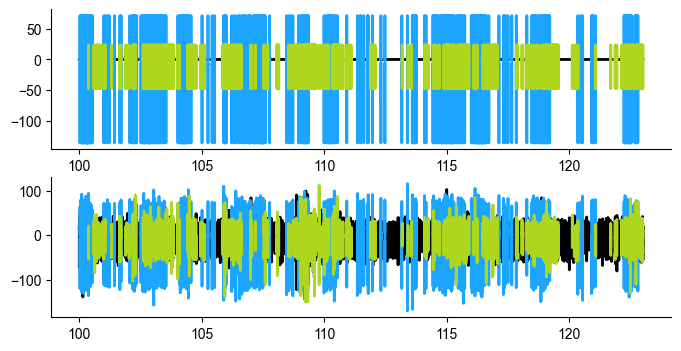

In [96]:
fig, ax = plt.subplots(2,1,figsize=(8,4))

ts_sig_nan = ts_signal.copy()
ts_sig_nan[spike_ind_sum != 0] = np.nan

orig_sig_nan = orig_channel_sig_ts.copy()
orig_sig_nan[spike_ind_sum != 0] = np.nan

ax[0].plot(orig_channel_sig_ta, ts_sig_nan, color='k', linewidth=2)
ax[1].plot(orig_channel_sig_ta, orig_sig_nan, color='k', linewidth=2)
for i,px in enumerate([0,3]):
    unit_spk_sig_nan1 = unit_spike_ts_list[i].copy()
    unit_spk_sig_nan2 = orig_channel_sig_ts.copy()
    unit_spk_sig_nan1[unit_spike_indicators[i] == 0] = np.nan
    unit_spk_sig_nan2[unit_spike_indicators[i] == 0] = np.nan
    ax[0].plot(orig_channel_sig_ta,unit_spk_sig_nan1,
               color=MISC6_PAL[px], linewidth=2)
    ax[1].plot(orig_channel_sig_ta,unit_spk_sig_nan2,
               color=MISC6_PAL[px], linewidth=2)
# ax[0].set_xlim(111,112.5)
# ax[1].set_xlim(111,112.5)

In [101]:
total_theor_psd = sel_firing_rates @ filter_psds

(300, 5000)

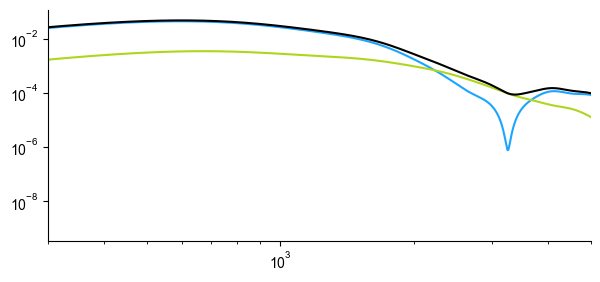

In [104]:
fig, ax = plt.subplots(figsize=(7,3))
ax.loglog(theor_freqs, filter_psds[0]*sel_firing_rates[0], color=MISC6_PAL[0])
ax.loglog(theor_freqs, filter_psds[1]*sel_firing_rates[1], color=MISC6_PAL[3])
ax.loglog(theor_freqs, total_theor_psd, color='k')
ax.set_xlim(300,5000)

In [48]:
u378_fr = calculate_ts_firing_rate(unit_spike_trains[0], fs)
u375_fr = calculate_ts_firing_rate(unit_spike_trains[1], fs)

pop_fr = calculate_ts_firing_rate(unit_spike_trains[0] + unit_spike_trains[1], fs)

In [27]:
fr_time = np.arange(time_window[0], time_window[1], 0.5)

In [90]:
filter_psds_interp = filter_psds[:,np.logical_and(theor_freqs >= 1, theor_freqs <= 5000)]

In [91]:
u_frs = np.array([u378_fr, u375_fr])

theor_specgram = u_frs.T @ filter_psds_interp

In [29]:
from fppnpx.FPPSSM import FPPSSM

In [105]:
fppssm = FPPSSM(ts_signal, orig_channel_sig_ta, fs, thbp=3.5)

In [107]:
fppssm.fit_mv(filter_psds, theor_freqs, x_bar=20, freq_range=(300,5000))

Instantiating model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_2, sigma, d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, d_10, d_11, d_12, d_13, d_14, d_15, d_16, d_17, d_18, d_19, d_20, d_21, d_22, d_23, d_24, d_25, d_26, d_27, d_28, d_29, d_30, d_31, d_32, d_33, d_34, d_35, d_36, d_37, d_38, d_39, d_40, d_41, d_42, d_43, d_44, d_45]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12508 seconds.
There were 1927 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [121]:
posterior_samps = []
rate_preds = []

for i in range(46):
    posterior_samp = fppssm.trace_back.posterior.data_vars[f'd_{i}']
    posterior_samps.append(posterior_samp)
    rate_preds.append(posterior_samp.mean(axis=(0,1)).values)

posterior_samps = np.array(posterior_samps)
rate_preds = np.array(rate_preds)

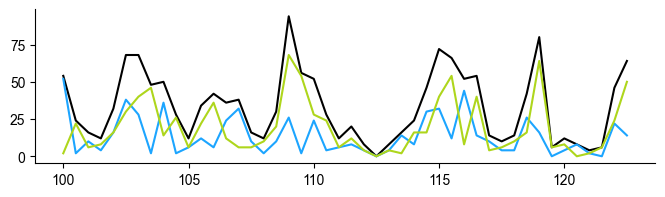

In [117]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(fr_time, pop_fr, color='k')
ax.plot(fr_time, u378_fr, color=MISC6_PAL[0])
ax.plot(fr_time, u375_fr, color=MISC6_PAL[3])

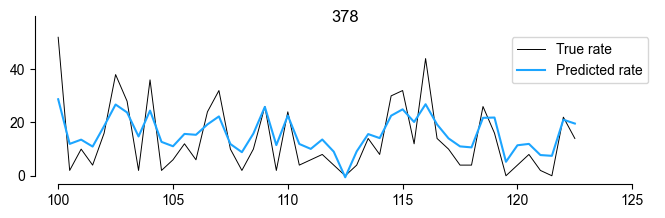

In [ ]:
# plt.plot(u1_fr, color='k', label='True rate')
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(fr_time, u378_fr, color='k', label='True rate', linewidth=0.7)
ax.plot(fr_time, rate_preds[:,0] + 20, color=MISC6_PAL[0], label='Predicted rate')
# ax.fill_between(fr_time, rate_preds[:,0] + 20 - rate_pred_stes[:,0], rate_preds[:,0] + 20 + rate_pred_stes[:,0], color=cmap(1), alpha=0.2)
ax.set_title("378")
ax.legend()
ax.set_xlim(99, 126)
ax.spines['bottom'].set_bounds(100, 125)
ax.spines['left'].set_bounds(0, 60)

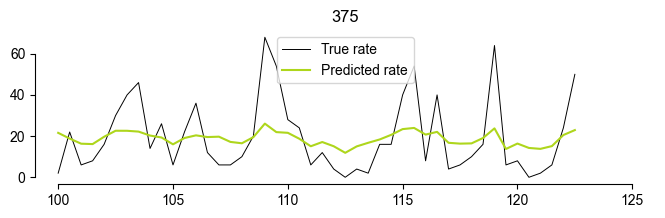

In [110]:
# plt.plot(u1_fr, color='k', label='True rate')
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(fr_time, u375_fr, color='k', label='True rate', linewidth=0.7)
ax.plot(fr_time, rate_preds[:,1] + 20, color=MISC6_PAL[3], label='Predicted rate')
# ax.fill_between(fr_time, rate_preds[:,0] + 20 - rate_pred_stes[:,0], rate_preds[:,0] + 20 + rate_pred_stes[:,0], color=cmap(1), alpha=0.2)
ax.set_title("375")
ax.legend()
ax.set_xlim(99, 126)
ax.spines['bottom'].set_bounds(100, 125)
ax.spines['left'].set_bounds(0, 60)

In [111]:
rate_preds_adj = rate_preds + 20
pred_spec = rate_preds_adj @ fppssm.S_f_interp_list

In [112]:
obs_spec = fn.spectrafuncs.multitaper_spectrogram(ts_signal, fs, time_halfbandwidth_product=3.5, window_duration=0.5, window_step=0.5, start_time=time_window[0])

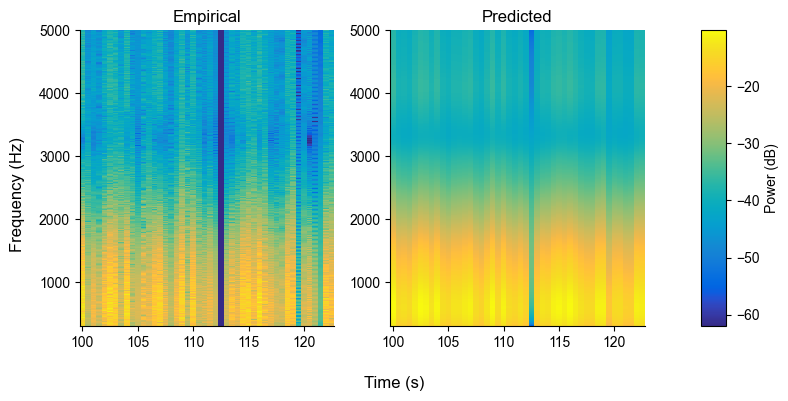

In [115]:
gridspec = {'width_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw=gridspec)

im = ax[0].pcolormesh(
    obs_spec.time,
    obs_spec.frequencies,
    10 * np.log10(obs_spec.power().squeeze().T + 1e-12),
    cmap=ml_map,
    shading="auto",
    vmin=-62
)
ax[0].set_ylim(300,5000)
ax[0].set_title("Empirical")

im2 = ax[1].pcolormesh(
    obs_spec.time,
    fppssm.spectrogram_trunc_freqs,
    10 * np.log10(pred_spec.T),
    cmap=ml_map,
    shading='auto',
    vmin=-62
)
ax[1].set_ylim(300,5000)
ax[1].set_title("Predicted")

fig.tight_layout()

fig.supxlabel("Time (s)")
fig.supylabel("Frequency (Hz)")

cax = ax[2]
fig.colorbar(im2, cax=cax, label='Power (dB)')
fig.tight_layout()